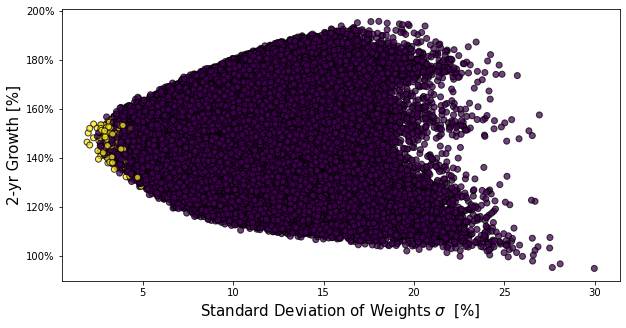

In [23]:
#number of stocks
n=8

#Upside, b
b=[3.24,
1.99,
1.70,
2.03,
2.76,
1.62,
4.97,
1.75]

#Downside, a
a =[0.15,
0.10,
0.09,
0.28,
0.47,
0.11,
0.28,
0.14]

#Probability of upside
p=[0.65,
0.70,
0.65,
0.65,
0.60,
0.70,
0.60,
0.65]

#Weights, W
#f=[0.17,
#0.15,
#0.06,
#0.11,
#0.16,
#0.09,
#0.17,
#0.09]

Fmax=1
fmax=0.17
y,f=MCG(n=n,b=b,a=a,p=p,runs=200000,Fmax=Fmax,constraint='=')

F=np.sum(f,axis=1)
S=np.std(f,axis=1)
isf=np.prod(f<fmax,axis=1)
#print(isf)

fig, ax = plt.subplots()
ax.scatter(S*100, (y-1)*100,c=isf,alpha=0.75,edgecolors='black')
ax.set_xlabel(r'Standard Deviation of Weights $\sigma$  [%]', fontsize=15)
ax.set_ylabel(r'2-yr Growth [%]', fontsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

# Appendix: Portfolio Optimization Using Pfoolio

We aim to define a simple method to allocate capital to a portfolio of various assets. Using only a few inputs of easy to interpret values. The outcome of the calculation is the desired weights to maximize the growth of the portfolio for the given assumption. The method follows a similar approach to that which is used to define the Kelly Criterion but now generalized to a portfolio of multiple assets.

All that's required is:
1) the number of stocks  
2) the probability of the base case for each stock    
3) the estimated gain (base case) or loss (bear case) for each stock in the portfolio   

For example a portfolio of 3 stocks could be input as simply as:

In [245]:
n=3 #the number of stocks in the portfolio, first required input
p = np.array([0.7,0.7,0.7]) #probability of the base case, second required input
b = [1,1,1] #upside gain, third required input
a = [0.5,0.5,0.5] #downside loss, third required input

That's it! We will show below how these are used to calculate optimal allocations to these 3 stock.

## What are the possible outcomes for our portfolio?

To illustrate the idea behind the portfolio optimizer, we will use the example of a portfolio of 3 stocks, each with potential upside and downside, and a likelihood of achieving them. We simplify the potential outcomes to say that for a given stock there are 2 discrete outcomes, either it achieves a specific base case or a specific bear case. Even with this simplification, when extending the problem to include a portfolio of companies, there are various potential outcomes, all stocks might be winners, all might be losers or some combination of winners and losers.In the case of the three stock portfolio, where a '1' represents a stock which achieves its 'base' case and '0' where a stock achieves its 'bear' case, the possible combinations are: 

In [133]:
n = 3  #the number of stocks in the portfolio, first required input

c = combination_tree(n)
print(c)

[[1. 1. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


With each row representing a possible outcome, and again because of our simplifications, the possible outcomes are finite with each stock either achieving a base case or bear case. Some of you will know that 3 events (i.e. stocks) with 2 outcomes (base/bear case) will have,
$$2^3=8$$ 
possible outcomes, which is exactly what we see above.


## What outcomes are most likely? 

Now, despite all these combinations being possible, they are not equally likely. We have chosen these stocks because we expect the base case to play out and that the bear case is unlikely. Let's continue our example and for simplicity sake let's say that on an individual level each of these have a 70% chance of success. It follows that the chance of them all achieving their base case would be 70%x70%x70%=34% (which might be lower then some would expect!). Conversily, the chance of all of them going bearish would be 30%x30%x30% = 2.7%. But we just saw that these are not the only possibilities. Following the same order as the scenarios above, the probabilities for each of these are as follows:

In [134]:
p = np.array([0.7,0.7,0.7]) #probability of the base case, second required input

P = pmf(c,p)
print(P)

[0.343 0.147 0.147 0.063 0.147 0.063 0.063 0.027]


The first and last numbers are the probabilities we discussed above, i.e. 34.3% and 2.7%, but now you can also see the likelihoods of all the other potential outcomes which were described in the combination tree.

Now that we know the probabilties of each of those outcomes we can also calculate the gain/loss which we would achieve in our portfolio. To do this we need to estimate the upside gain, the downside gain and we need to decide how much to allocate. Say we have a stock wich gains 100% and is 1/3 of our portfolio, this will contribute a gain of: 1/3x100%=33% at the portfolio level. Or say it loses 50% if things go unfavourably, then the loss would be: 1/3x50%=16.6% at the portfolio level.

And then for example, if 2 stocks do well and 1 loses, the net gain is then, 1/3x100+ 1/3x100 - 1/3x50 = 50% return

This calculation can be repeated for all the combinations above.

In [135]:
b = [1,1,1] #upside gain, third required input
a = [0.5,0.5,0.5] #downside loss, third required input
f = [1/n,1/n,1/n] #portfolio weights

R=net_gain(b,a,c,f)
print(R)

[ 1.   0.5  0.5  0.   0.5  0.   0.  -0.5]


Interestingly a concentrated portfolio of stocks which we stongly believe to double (i.e. 100% return with 70% confidence) may produce returns quite a bit lower than this. In this case it's mostly because the downside was pretty large, but the idea is still worth keeping in mind. We can further visualize the data using a histogram.

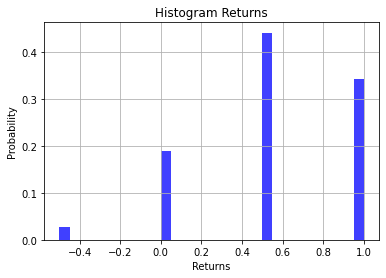

In [136]:
# the histogram of the data
n, bins, patches = plt.hist(R, 30, facecolor='b', alpha=0.75, weights=P)
plt.xlabel('Returns')
plt.ylabel('Probability')
plt.title('Histogram Returns')
plt.grid(True)
plt.show()

## How much should we invest? *Portfolio growth and stock weights* 

Finally we can combine all these calculations to estimate the portfolio growth. Conceptually what is done is that assume that the portfolio compounds with varying returns (as calculated by the net gains) in proportion to the probabilities which we have caculated. Perhaps you're expecting this to be a complicated formula but it's relatively simple expression. 

$$G =\prod \limits _{i=1} ^{k}(1+R(f_{n})_{i})^{P_{i}}$$

But in any event, no need to spend too much time on this. It's the same equation maximized in to calculate the well known Kelly Criterion but generalized to a portfolio with more then 2 outcomes.$R(f_{n})$ and $P$ represent the net gains and probabilities which we have calculated above. Continuing with out 3 stock example, in an equally weighted portfolio, with no leverage (remember $f=1/3$, so for 3 stocks we are fully invested) the portfolio growth is,

In [162]:
growth(R,P)

1.4886127138727536

In [306]:
n=3 #the number of stocks in the portfolio, first required input
p = np.array([0.7,0.7,0.7]) #probability of the base case, second required input
b = [1,1,1] #upside gain, third required input
a = [0.5,0.5,0.5] #downside loss, third required input
f= [1/n,1/n,1/n]
g=growth_wrapper(f,b,a,p)
print(g)

1.4886127138727536


In other words, 48.8% growth.

Now comes the important part, we can use this to choose the theoretically *ideal* weighting of our stocks and the amount of cash we should hold too. We do this by finding the portfolio weights $f_{i}$, which will give our portfolio the highest expected growth. Because all three stocks have the exact same characteristics, it stands to reason that they should all be equally allocated, but the question still remains how much of the overall 'bankroll' should be allocated? 

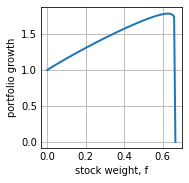

In [307]:
F = np.linspace(0, 2/3, 100)
g = np.zeros(len(F))

for i in range(len(F)):
    f = [F[i],F[i],F[i]]
    g[i]=growth_wrapper(f,b,a,p)

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
ax.plot(F, g, linewidth=2.0)
ax.set(xlabel='stock weight, f', ylabel='portfolio growth')

plt.show() 

We see here that each stock should have a weighting of just over $f=0.6$. Which in other words means the portfolio should be levered i.e. 3x0.6=1.8 (in theory!).  

### Example: Coin Toss with 70% Chance of Heads

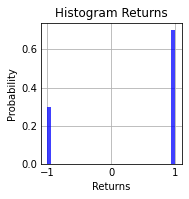

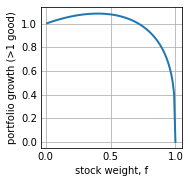

In [378]:
n=1 #the number of stocks in the portfolio, first required input
p = 0.7 #probability of the base case, second required input
b = 1 #upside gain, third required input
a = 1 #downside loss, third required input
fmax=1

gvis(n,fmax,b,a,p)

### Example: Two Coin Tosses with 70% Chance of Heads

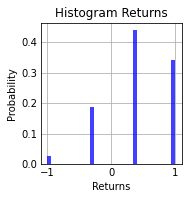

C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_28212\3591834737.py:40: RuntimeWarning: invalid value encountered in double_scalars
  g=g*(1+R[i])**P[i]


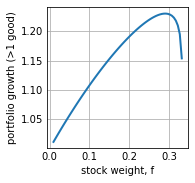

In [489]:
n=3 #the number of stocks in the portfolio, first required input
p = 0.7 #probability of the base case, second required input
b = 1 #upside gain, third required input
a = 1 #downside loss, third required input
fmax=0.5

gvis(n,fmax,b,a,p)

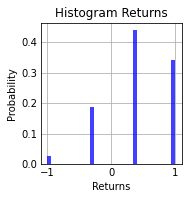

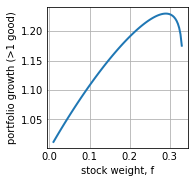

In [42]:
n=3 #the number of stocks in the portfolio
p = 0.7 #probability of the base case
b = 1 #upside gaint
a = 1 #downside loss
fmax = 0.33

gvis(n,fmax,b,a,p)

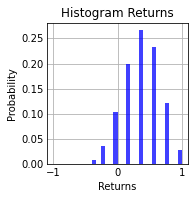

C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_28212\2459512674.py:40: RuntimeWarning: invalid value encountered in double_scalars
  g=g*(1+R[i])**P[i]


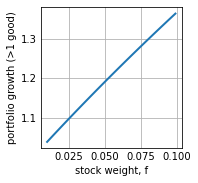

In [381]:
n=10 #the number of stocks in the portfolio, first required input
p = 0.7 #probability of the base case, second required input
b = 1 #upside gain, third required input
a = 1 #downside loss, third required input
fmax=0.5

gvis(n,fmax,b,a,p)

In [476]:
print(weight_generator(5,Fmax=1,constraint='<'))

[0.30414789 0.00717953 0.10570471 0.05522241 0.51575846]


In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from itertools import product
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np

def combination_tree(n):
    '''generate a tree of all possible combination'''
    c = np.array([1,0])
    num_cols = 2
    for i in range(n-1):
        c1 = np.vstack((c,np.ones(num_cols)))
        cz = np.vstack((c,np.zeros(num_cols)))
        c = np.hstack((c1,cz))
        num_rows, num_cols = c.shape
    return np.transpose(c)

def pmf(c,p):
    '''generate the probabilities if each outcome defined in the probability tree'''
    try:
        num_rows, num_cols = c.shape
    except:
        num_rows = 2**len(p)
    P = np.ones(num_rows)
    for j in range(len(p)):
        if num_rows == 2: #single stock case
            P = np.multiply(P,(c*p[j]+(1-c)*(1-p[j])))
        else:
            P = np.multiply(P,(c[:,j])*p[j]+(1-c[:,j])*(1-p[j]))
    return P

def net_gain(b,a,c,f):
    '''calculate the array of net gains'''
    if len(b)==1:
        R=c*f*b-(1-c)*f*a
    else:
        R=np.matmul(c,np.multiply(f,b))-np.matmul(1-c,np.multiply(f,a))
    return R

def growth(R,P):
    g=1
    for i in range(len(P)):
        g=g*(1+R[i])**P[i]
    return g

def growth_wrapper(f,b,a,p):
    n=len(f)
    c=combination_tree(n)
    P=pmf(c,p)
    R=net_gain(b,a,c,f)
    g=growth(R,P)
    return g

def gvis(n,fmax,b,a,p):
    '''histgram and growth curve for multiple, independant bets.
    histogram assuming weights are equal, fully invested'''

    f=np.ones(n)*1/n
    b=np.ones(n)*b
    a=np.ones(n)*a
    p=np.ones(n)*p
    
    c=combination_tree(n)
    P=pmf(c,p)
    R=net_gain(b,a,c,f)

    fig, ax = plt.subplots()
    N, bins, patches = plt.hist(R, 30, facecolor='b', alpha=0.75, weights=P)
    plt.xlabel('Returns')
    plt.ylabel('Probability')
    plt.title('Histogram Returns')
    plt.grid(True)
    plt.show()

    F = np.linspace(0.01, fmax, 100)
    g = np.zeros(len(F))

    for i in range(len(F)):
        f=np.ones(n)*F[i]
        g[i]=growth_wrapper(f,b,a,p)

    plt.style.use('_mpl-gallery')
    fig, ax = plt.subplots()
    ax.plot(F, g, linewidth=2.0)
    ax.set(xlabel='stock weight, f', ylabel='portfolio growth (>1 good)')

    plt.show()
    
def weight_generator(n,Fmax=1,constraint='<'):
    if constraint=='<':
        n=n
    elif constraint=='=':
        n=n-1
        
    f=np.zeros(n)
    pt=np.zeros(n)
    for i in range(n):
        pt[i]=np.random.default_rng().uniform(low=0,high=Fmax)
    pts=np.insert(np.sort(pt),0,0)
    if constraint=='<':
        pass
    elif constraint=='=':
        pts=np.append(pts,Fmax)
    f=np.diff(pts)
    return f

def MCG(n,b,a,p,runs=2,Fmax=1,constraint='<'):
    f=np.zeros((runs,n))
    y=np.zeros(runs)
    for i in range(runs):
        f[i]=weight_generator(n,Fmax,constraint)
        y[i]=growth_wrapper(f[i],b,a,p)
    return y,f

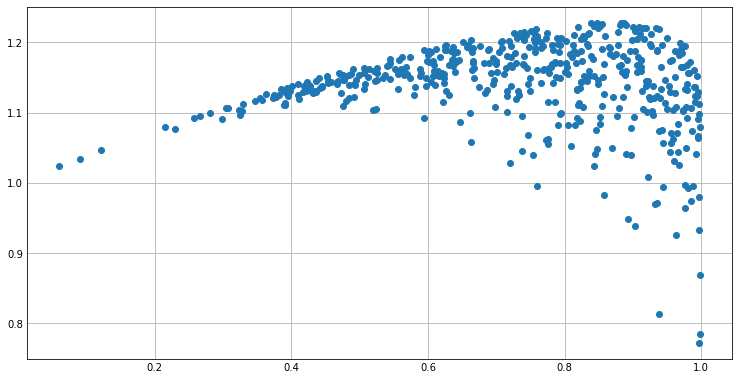

In [509]:
y,f=MCG(n=3,b=[1,1,1],a=[1,1,1],p=[0.7,0.7,0.7],runs=500,Fmax=1,constraint='<')

#print(y)
#print(f)
F=np.sum(f,axis=1)
#print(F)

fig, ax = plt.subplots()
ax.scatter(F, y)
plt.show()

In [22]:
np.array(list(product(range(2), repeat=4)))

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])